In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from divopt.evaluation.process_results import (
    get_ranks,
    get_sorted_optimizers,
    load_results,
)

In [5]:
runs_base = "../runs/"

results_dict = load_results(runs_base)
limit_names = list(results_dict.keys())

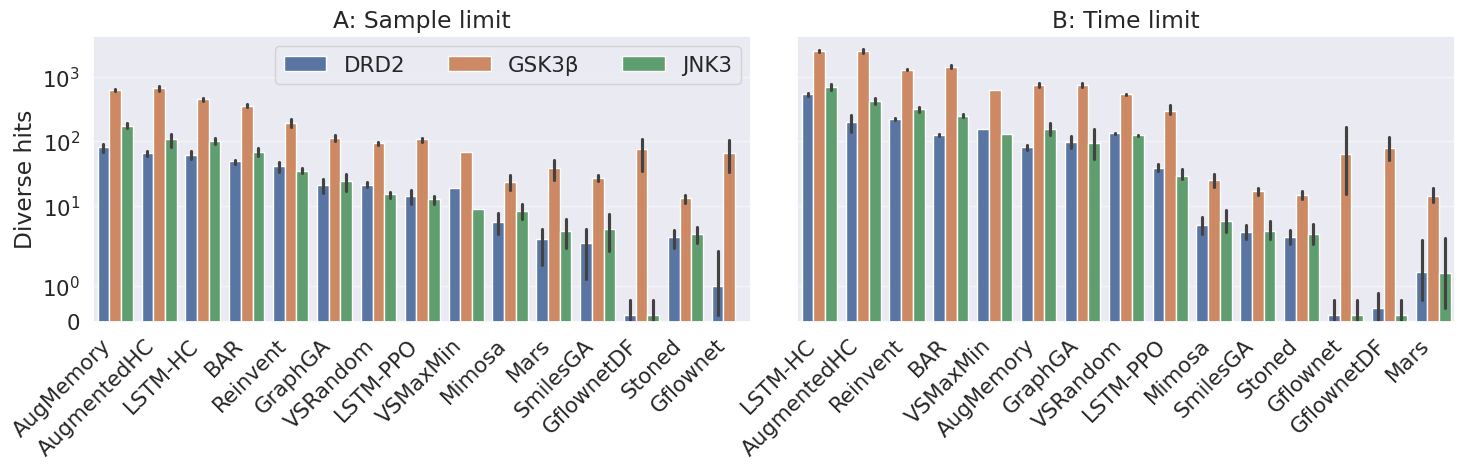

In [8]:
title_dict = {
    "samples": "A: Sample limit",
    "time": "B: Time limit",
}
sns.set_theme(font_scale=1.4)

fig, axes = plt.subplots(figsize=(15, 5), sharey=True, ncols=2, nrows=1)
for ax, limit_name in zip(axes, limit_names):
    plt.sca(ax)
    results = results_dict[limit_name]
    sns.barplot(
        x="Optimizer",
        y=f"n_diverse_all_{limit_name}",
        hue="Task",
        data=results,
        order=get_sorted_optimizers(results, limit_name),
    )
    # rotate xlabels
    plt.xticks(rotation=45, horizontalalignment="right")
    plt.xlabel("")
    plt.ylabel("")
    plt.title(title_dict[limit_name])
    plt.yscale("symlog")
    # add minor ticks

    locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=6)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    plt.grid(axis="y", linestyle="-", alpha=0.5, linewidth=1)  # Add gridlines to y-axis
    # plt.savefig(f"figures/divhits_barplot_{limit_name}.pdf", bbox_inches="tight")

axes[0].set_ylabel("Diverse hits")
axes[0].legend_.remove()
# make legend with three columns
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend_.remove()
axes[1].legend(
    handles,
    labels,
    loc="upper right",
    bbox_to_anchor=(-0.07, 1.0),
    ncol=3,
)
# add A. and B. labels in upper left corner
# axes[0].text(-0.12, 1.1, "A", transform=axes[0].transAxes, fontsize=16, fontweight="normal", va="top")
# axes[1].text(1.05, 1.1, "B", transform=axes[0].transAxes, fontsize=16, fontweight="normal", va="top")
plt.tight_layout()
plt.subplots_adjust(wspace=0.07)
plt.savefig("figures/divhits_barplot_combined.pdf", bbox_inches="tight")
plt.show()

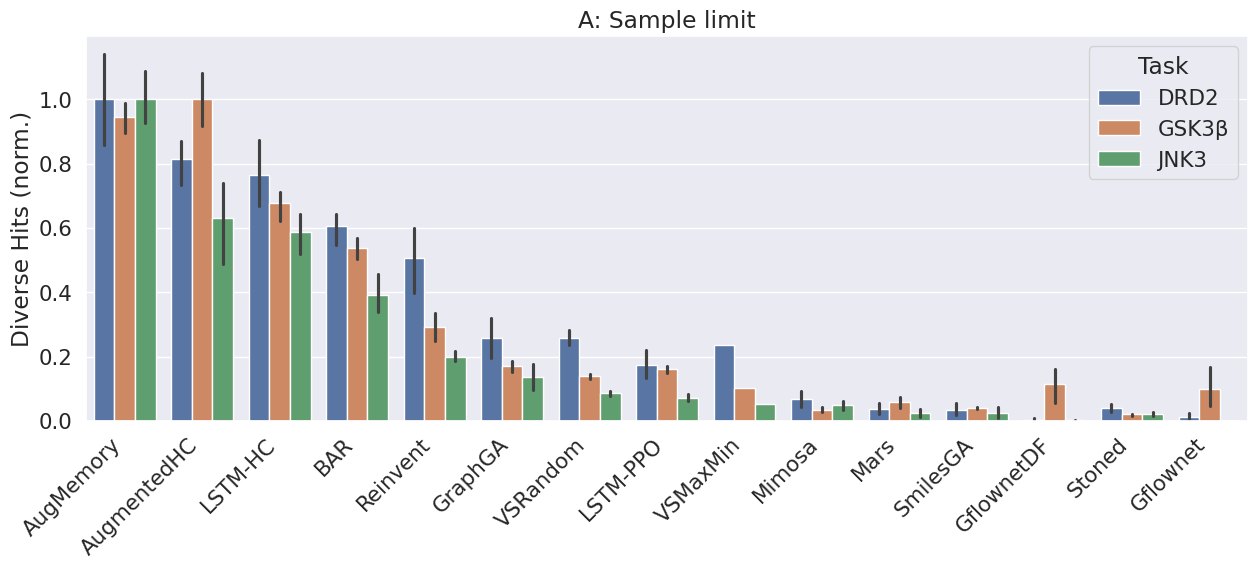

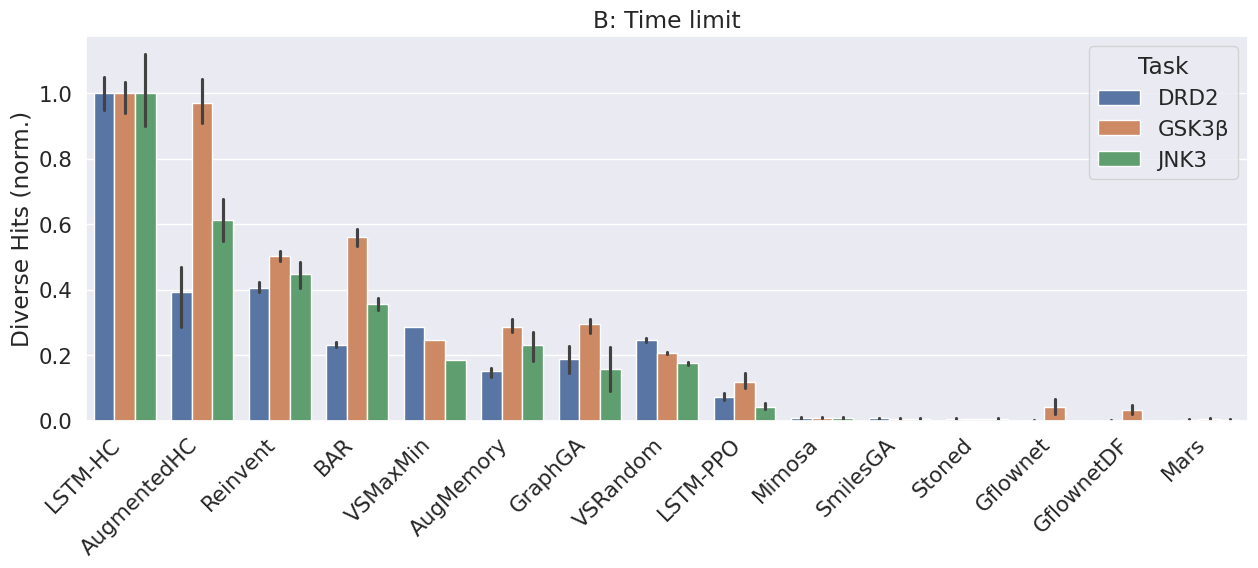

In [9]:
for limit_name in limit_names:
    results = results_dict[limit_name]
    # Step 1: Calculate the maximum values for each task
    mean_values = results.groupby(["Task", "Optimizer"])[f"n_diverse_all_{limit_name}"].transform("mean")
    results["mean_values"] = mean_values
    max_values = results.groupby("Task")["mean_values"].transform("max")
    # Step 2: Normalize the values in the dataframe
    results["normalized_n_diverse"] = results[f"n_diverse_all_{limit_name}"] / max_values

    # change font size to 14
    sns.set(font_scale=1.4)

    # Step 3: Plot the normalized values
    plt.figure(figsize=(15, 5))
    sns.barplot(
        x="Optimizer",
        y="normalized_n_diverse",
        hue="Task",
        data=results,
        order=get_sorted_optimizers(results, limit_name),
    )
    plt.ylabel("Normalized n_diverse_all_samples")
    plt.xticks(rotation=45, horizontalalignment="right")
    plt.xlabel("")
    plt.ylabel("Diverse Hits (norm.)")
    plt.title(title_dict[limit_name])
    plt.show()

In [10]:
limit_name_dict = {"samples": "Sample", "time": "Time"}
ranks_list = []
for limit_name in limit_names:
    results = results_dict[limit_name]
    ranks = get_ranks(results, limit_name)
    # create multiindex for columns with limit name as first level
    ranks.columns = pd.MultiIndex.from_product([[limit_name_dict[limit_name]], ranks.columns])
    ranks_list.append(ranks)

ranks = pd.concat(ranks_list, axis=1)
ranks["Mean Rank"] = ranks.mean(1)
ranks = ranks.sort_values("Mean Rank")

In [11]:
norm_list = []
for limit_name in limit_names:
    results = results_dict[limit_name]

    # Step 1: Calculate the mean values for each task
    mean_values = results.groupby(["Task", "Optimizer"])[f"n_diverse_all_{limit_name}"].transform("mean")
    results["mean_values"] = mean_values
    max_values = results.groupby("Task")["mean_values"].transform("max")
    # Step 2: Normalize the values in the dataframe
    results["normalized_n_diverse"] = results[f"n_diverse_all_{limit_name}"] / max_values
    mean = results.pivot_table(
        index="Optimizer",
        columns="Task",
        values="normalized_n_diverse",
        aggfunc="mean",
    )
    mean.columns = pd.MultiIndex.from_product([[limit_name_dict[limit_name]], mean.columns])
    norm_list.append(mean)

norm = pd.concat(norm_list, axis=1)
norm["Mean norm. perf."] = norm.mean(1)
norm = norm.sort_values("Mean norm. perf.", ascending=False)

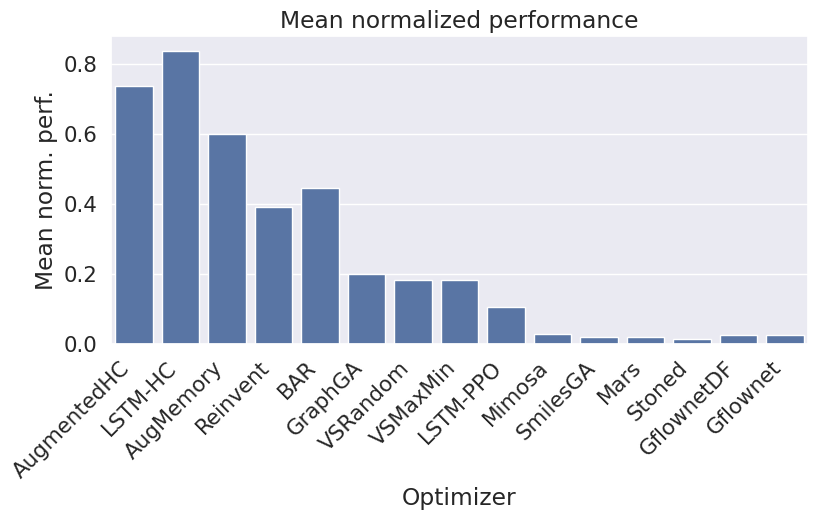

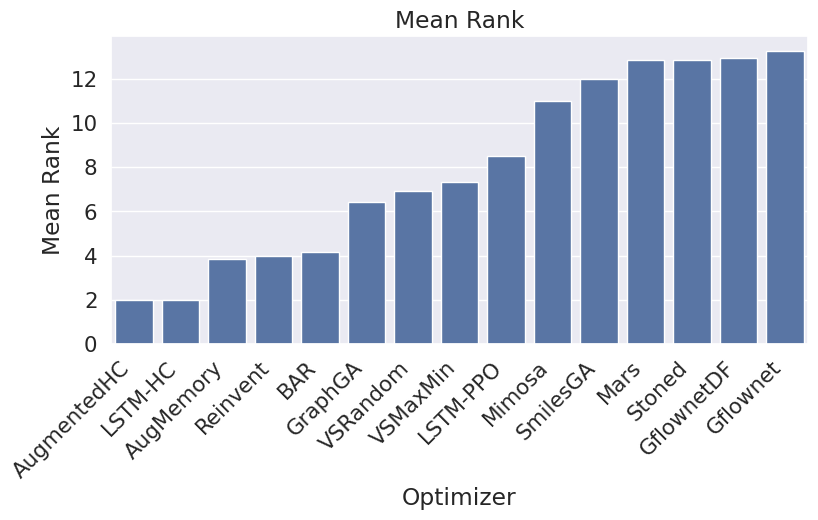

In [12]:
ranks_norm = ranks.merge(norm, how="inner", left_index=True, right_index=True, suffixes=("_rank", "_norm"))

plt.figure(figsize=(9, 4))
sns.barplot(
    x="Optimizer",
    y="Mean norm. perf.",
    data=ranks_norm.reset_index(),
)
plt.xticks(rotation=45, horizontalalignment="right")
plt.title("Mean normalized performance")
plt.show()

ranks_norm = ranks.merge(norm, how="inner", left_index=True, right_index=True, suffixes=("_rank", "_norm"))
plt.figure(figsize=(9, 4))
sns.barplot(
    x="Optimizer",
    y="Mean Rank",
    data=ranks_norm.reset_index(),
)
plt.xticks(rotation=45, horizontalalignment="right")
plt.title("Mean Rank")
plt.show()

Sample                          Time                    
Task             DRD2     GSK3β      JNK3      DRD2     GSK3β      JNK3
Optimizer                                                              
LSTM-HC      0.765432  0.676759  0.586364  1.000000  1.000000  1.000000
AugmentedHC  0.814815  1.000000  0.629545  0.392503  0.970537  0.611519
AugMemory    1.000000  0.943603  1.000000  0.150680  0.287230  0.230096
BAR          0.607407  0.536361  0.390909  0.231533  0.560644  0.355731
Reinvent     0.506173  0.293262  0.200000  0.406101  0.502023  0.448899
GraphGA      0.256790  0.170971  0.137500  0.187431  0.295321  0.156973

Text(0.5, 1.0, 'Pearson correlation of \n normalized performance')

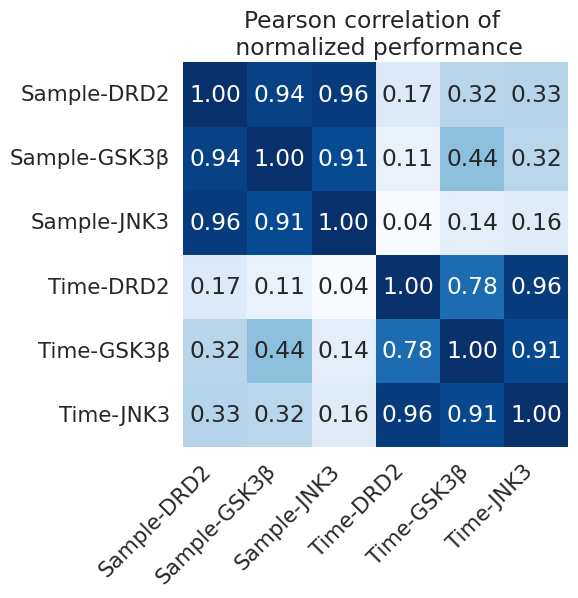

In [13]:
# drop mean perf
norm_corr = norm.drop("Mean norm. perf.", axis=1).iloc[:6]
display(norm_corr)
corr_matrix = norm_corr.corr(method="pearson")

plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, annot=True, cmap="Blues", fmt=".2f", square=True, cbar=False)
plt.xticks(rotation=45, horizontalalignment="right")
# plt.yticks(rotation=45, verticalalignment='top');
plt.xlabel("")
plt.ylabel("")
plt.title("Pearson correlation of \n normalized performance")